# PROJECT 2
### Objective: Setup a web scraping pipeline to scrape data from at least five pages from https://www.basketball-reference.com/. 
* Place the data in a pandas DataFrame,
* clean the data, if necessary,
* and then perform data analysis that answers a minimum of four questions about the data.
* Answers should be given programmatically as output and at least two questions should have answers demonstrated via a plot.
* Restriction: Crawl/request delay of 3 seconds must be followed as per robots.txt on basketball-reference.com.

### We will scrape data to answer the following questions:
1. Do teams with higher assist averages have better win records? 
2. How has LeBron James’ scoring efficiency (TS%, PER) changed over the last 10 years?
3. Which teams in the eastern conference had the best win-lose percentage and how does it correlate with opponent points per game? 
4. How did LeBron James' 2023–2024 season compare to his career averages in key stats like points, assists, and minutes per game?

# <u>Imports</u>
## Import libraries
* Requests: Allows webpages to be pulled
* BeautifulSoup: Allows for webscraping
* Selenium and webdriver: Allows for webscraping where other methods produce errors. Requires installation.
* Pandas: Allows for dataframe manipulation
* Time: Allows for crawl/request delay in order to abide by robots.txt of website we are pulling from
* traceback: Allows for handling of errors
* statistics, matplotlib.pyplot, and seaborn: Allows for plotting of data

In [95]:
import requests
from bs4 import BeautifulSoup, Comment
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import traceback
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns 

## Setting up webdriver
* Goal: Set up headless WebDriver.

In [96]:
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
driver = webdriver.Chrome(service=Service(), options=options)

# <u>Part 1: Webscraping & Pandas Dataframe</u>
### Objective: Scrape the data from the webpages and load the data into pandas dataframes


### Define the URLs to scrape

In [97]:
urls = {
    "season_summary": "https://www.basketball-reference.com/leagues/NBA_2025.html",
    "lakers_2024": "https://www.basketball-reference.com/teams/LAL/2024.html",
    "lebron_stats": "https://www.basketball-reference.com/players/j/jamesle01.html",
    "coaches": "https://www.basketball-reference.com/leagues/NBA_2025_coaches.html",
    "draft": "https://www.basketball-reference.com/draft/NBA_2024.html",
    "lakers_2025": "https://www.basketball-reference.com/teams/LAL/2025.html"
}


### Function to scrape pages

In [98]:
def get_table_by_id(driver, url, table_id):
    driver.get(url)
    time.sleep(3)  # Polite wait
    html = driver.page_source

    # First try: Normal read_html
    try:
        table = pd.read_html(html, attrs={"id": table_id})[0]
        print(f"Found '{table_id}' using pd.read_html().")
        return table
    except ValueError:
        print(f"'{table_id}' not found directly with read_html. Trying inside HTML comments...")

    # Fallback: Try to find table inside comments
    soup = BeautifulSoup(html, "html.parser")
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))

    for comment in comments:
        if table_id in comment:
            try:
                comment_soup = BeautifulSoup(comment, "html.parser")
                table = pd.read_html(str(comment_soup.find("table", {"id": table_id})))[0]
                print(f"Found '{table_id}' inside HTML comment.")
                return table
            except Exception as e:
                print(f"Error parsing table inside comment: {e}")
                return None

    print(f"Table '{table_id}' not found in HTML or comments.")
    return None


### <u>Question 1:</u> Do teams with higher assist averages have better win records?
#### Objective: Pull each NBA team’s assists per game and win percentage from the 2024–25 Season Summary page.
### WARNING: results in error 
* Fetch the Season Summary page via requests.
* Parse out the “Per Game Stats” table (id="per_game-team") and the “Advanced Stats” table (id="advanced-team") with BeautifulSoup.
* Load both tables into pandas via pd.read_html().
* Clean and convert the relevant columns:
* From per-game: team name (Team) and assists per game (AST).
* From advanced: wins (W), losses (L), and win-loss percentage (W/L%).
* Merge on the Team column.
* Filter out any league-summary or header/footer rows.
* Ready the combined DataFrame for plotting.

In [127]:
chrome_options = Options()
chrome_options.add_argument("--headless")

driver = webdriver.Chrome(options=chrome_options)
driver.get("https://www.basketball-reference.com/leagues/NBA_2025.html")

page_source = driver.page_source
driver.quit()

In [128]:
season_url = "https://www.basketball-reference.com/leagues/NBA_2025.html"
table_id = "confs_standings_E"
season_df = get_table_by_id(driver, season_url, table_id)

if season_df is not None:
    #Clean
    print(season_df.head())
else:
    print("Table could not be extracted.")

MaxRetryError: HTTPConnectionPool(host='localhost', port=54754): Max retries exceeded with url: /session/3da481baaf5b5a904a76ad6bf108f0fb/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000022DA01C9480>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

#### Parse HTML, Extract AST/G from per_game-team table, Extract Win% from both conference standings

In [ ]:
tree = html.fromstring(page_source)

#Extract AST/G from per_game-team table
per_game_rows = tree.xpath('//table[@id="per_game-team"]/tbody/tr[not(contains(@class,"thead"))]')

teams = []
ast_per_g = []
for row in per_game_rows:
    team = row.xpath('.//td[@data-stat="team_name"]/a/text()')[0].strip()
    ast   = row.xpath('.//td[@data-stat="ast_per_g"]/text()')[0]
    teams.append(team)
    ast_per_g.append(float(ast))

#Extract Win% from both conference standings
pct_map = {}
for conf in ("E","W"):
    rows = tree.xpath(f'//table[@id="confs_standings_{conf}"]/tbody/tr[not(contains(@class,"thead"))]')
    for row in rows:
        team = row.xpath('.//td[@data-stat="team_name"]/a/text()')[0].strip()
        pct  = row.xpath('.//td[@data-stat="win_loss_pct"]/text()')[0]
        pct_map[team] = float(pct)

#Build combined DataFrame
season_df = pd.DataFrame({
    "team":      teams,
    "ast_per_g": ast_per_g
})
season_df["win_pct"] = season_df["team"].map(pct_map)
season_df = season_df.dropna().reset_index(drop=True)


### <u>Question 2:</u> How has LeBron James’ scoring efficiency (TS%, PER) changed over the last 10 years?
* Load LeBron's stats page: https://www.basketball-reference.com/players/j/jamesle01.html 
* Parse the advanced stats table (id="advanced")
* Extract rows for the last 10 seasons
* Get the season year, TS%, and PER for each
* Load the data into a dataframe

In [99]:
lebron_url = "https://www.basketball-reference.com/players/j/jamesle01.html"
table_id = "advanced"
lebron_advanced_df = get_table_by_id(driver, lebron_url, table_id)

if lebron_advanced_df is not None:
    # Clean or filter as needed
    print(lebron_advanced_df.head())
else:
    print("Table could not be extracted.")

C:\Users\pmost\AppData\Local\Temp\ipykernel_19920\448953020.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html, attrs={"id": table_id})[0]


Found 'advanced' using pd.read_html().
    Season Age Team   Lg Pos   G  GS    MP   PER   TS%  ...  USG%   OWS  DWS  \
0  2003-04  19  CLE  NBA  SG  79  79  3122  18.3  .488  ...  28.2   2.4  2.6   
1  2004-05  20  CLE  NBA  SF  80  80  3388  25.7  .554  ...  29.7   9.7  4.6   
2  2005-06  21  CLE  NBA  SF  79  79  3361  28.1  .568  ...  33.6  12.0  4.3   
3  2006-07  22  CLE  NBA  SF  78  78  3190  24.5  .552  ...  31.0   8.0  5.7   
4  2007-08  23  CLE  NBA  SF  75  74  3027  29.1  .568  ...  33.5  10.7  4.6   

     WS WS/48 OBPM  DBPM   BPM VORP         Awards  
0   5.1  .078  2.3  -0.6   1.7  2.9    MVP-9,ROY-1  
1  14.3  .203  7.0   1.7   8.6  9.1  MVP-6,AS,NBA2  
2  16.3  .232  7.5   1.6   9.1  9.4  MVP-2,AS,NBA1  
3  13.7  .206  5.9   2.2   8.1  8.1  MVP-5,AS,NBA2  
4  15.2  .242  8.2   2.6  10.9  9.8  MVP-4,AS,NBA1  

[5 rows x 29 columns]


### <u>Question 3:</u> Which teams in the eastern conference had the best win-lose percentage and how does it correlate with opponent points per game?
## WARNING: Results in error
* Load 2024-25 season stat page with Selenium
* Parse the advanced stats table (id="advanced")
* Get the team name, win-lose percentage, and opponent points per game
* Load the data into a dataframe

In [139]:
season_url = "https://www.basketball-reference.com/leagues/NBA_2025.html"
table_id = "confs_standings_E"
season_advanced_df = get_table_by_id(driver, season_url, table_id)

if season_advanced_df is not None:
    # Clean or filter as needed
    print(season_advanced_df.head())
else:
    print("Table could not be extracted.")

MaxRetryError: HTTPConnectionPool(host='localhost', port=56466): Max retries exceeded with url: /session/191ef336b9ee800601fd94e5750e13c2/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000022DA01CB680>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

### Parse data with lxml

In [132]:
tree = html.fromstring(page_source)

# Extract rows from the Eastern Conference standings table
rows = tree.xpath('//table[@id="confs_standings_E"]/tbody/tr[not(contains(@class,"thead"))]')

teams, win_pct, opp_ppg = [], [], []
for row in rows:
    team_name = row.xpath('.//td[@data-stat="team_name"]/a/text()')[0].strip()
    pct_text  = row.xpath('.//td[@data-stat="win_loss_pct"]/text()')[0]
    opp_text  = row.xpath('.//td[@data-stat="opp_pts_per_g"]/text()')[0]
    
    teams.append(team_name)
    win_pct.append(float(pct_text))
    opp_ppg.append(float(opp_text))

# Build DataFrame
df = pd.DataFrame({
    "team":      teams,
    "win_pct":   win_pct,
    "opp_ppg":   opp_ppg
})

AttributeError: 'str' object has no attribute 'fromstring'

### <u>Question 4:</u> How did LeBron James' 2023–2024 season compare to his career averages in key stats like points, assists, and minutes per game
#### ERROR
* Setup headless chrome
* Navigate to the page
* Grab the rendered HTML
* Parse and extract table data using lxml

In [141]:
url = "https://www.basketball-reference.com/players/j/jamesle01.html"
driver.get(url)
page_source = driver.page_source
driver.quit()

MaxRetryError: HTTPConnectionPool(host='localhost', port=56466): Max retries exceeded with url: /session/191ef336b9ee800601fd94e5750e13c2/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000022DA9CAB570>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

# <u>Part 2: Data Cleaning</u>
### Objective: Rid the data of any missing or irrelevant values.

### <b>Question 2:</b> How has LeBron James’ scoring efficiency (TS%, PER) changed over the last 10 years?
* Read all the tables from the page
* Identify the advanced table
* Filter last 10 seasons
* Convert to numeric (some cells may contain "--" or missing values)
* Print only relevant columns from past 10 seasons (Season, TS%, PER)

In [101]:
#Define URL
url = "https://www.basketball-reference.com/players/j/jamesle01.html"

#Read all tables from page
tables = pd.read_html(url)

#Identify the advanced table
#The advanced table typically has a column named 'Season' and 'PER'
adv = None
for tbl in tables:
    if 'PER' in tbl.columns and 'TS%' in tbl.columns:
        adv = tbl.copy()
        break

if adv is None:
    raise ValueError("Advanced table not found")

#Clean column names and convert to numeric
adv = adv.rename(columns={'TS%': 'TS_pct', 'PER': 'PER'})
adv['TS_pct'] = pd.to_numeric(adv['TS_pct'], errors='coerce')
adv['PER']    = pd.to_numeric(adv['PER'], errors='coerce')

#Filter the last 10 seasons (assuming table sorted chronologically)
#Drop rows that are career totals or headers
adv = adv[adv['Season'].str.contains('-', na=False)]
last10 = adv.tail(10).reset_index(drop=True)

print(last10[['Season', 'TS_pct', 'PER']])

    Season  TS_pct   PER
0  2015-16   0.588  27.5
1  2016-17   0.619  27.0
2  2017-18   0.621  28.6
3  2018-19   0.588  25.6
4  2019-20   0.577  25.5
5  2020-21   0.602  24.2
6  2021-22   0.619  26.2
7  2022-23   0.583  23.9
8  2023-24   0.630  23.7
9  2024-25   0.604  22.7


# <u>Part 3: Data Analysis</u>
### Objective: Analyze 4 questions about the data and plot the results.
### Questions:
1. Do teams with higher assist averages have better win records? (plot)
2. How has LeBron James’ scoring efficiency (TS%, PER) changed over the last 10 years?
3. Which teams in the eastern conference had the best win-lose percentage and how does it correlate with opponent points per game? (plot)
4. How did LeBron James' 2023–2024 season compare to his career averages in key stats like points, assists, and minutes per game?

## 1. Do teams with higher assist averages have better win records?
### ERROR
### Create the plot:
* Use Seaborn’s styling for cleaner visuals
* Create the figure and axis objects
* Plot TS% on the left y-axis
* Create a twin axis for PER
* Add a combined legend
* Title and layout adjustments

In [130]:
plt.figure(figsize=(10,6))

#Colors
colors = plt.get_cmap("tab20").colors
for i, row in season_df.iterrows():
    plt.scatter(row.ast_per_g, row.win_pct,
                color=colors[i % len(colors)],
                s=100, alpha=0.8)
    plt.text(row.ast_per_g + 0.1, row.win_pct + 0.005,
             row.team, fontsize=9)

plt.xlabel("Assists Per Game (AST/G)")
plt.ylabel("Win Percentage (W/L%)")
plt.title("2024–25 NBA: AST/G vs Win% by Team")
plt.grid(alpha=0.3)

#Show Pearson correlation
r = np.corrcoef(season_df.ast_per_g, season_df.win_pct)[0,1]
plt.figtext(0.15, 0.85, f"Pearson r = {r:.2f}", color="gray")

plt.tight_layout()
plt.show()


NameError: name 'season_df' is not defined

<Figure size 1000x600 with 0 Axes>

## 2. How has LeBron James’ scoring efficiency (TS%, PER) changed over the last 10 years?
### Create the plot:
* Use Seaborn’s styling for cleaner visuals
* Create the figure and axis objects
* Plot TS% on the left y-axis
* Create a twin axis for PER
* Add a combined legend
* Title and layout adjustments

C:\Users\pmost\AppData\Local\Temp\ipykernel_19920\2263356023.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(last10["Season"], rotation=45, ha="right")


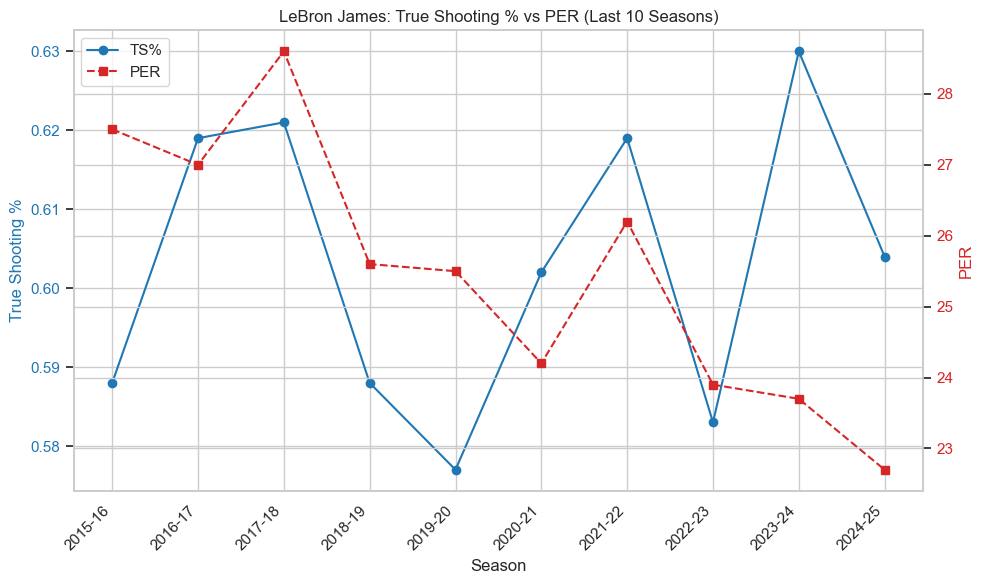

In [105]:
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

#Plot TS% on the left y-axis
color_ts = "tab:blue"
ax1.plot(last10["Season"], last10["TS_pct"], marker="o", color=color_ts, label="TS%")
ax1.set_xlabel("Season")
ax1.set_ylabel("True Shooting %", color=color_ts)
ax1.tick_params(axis="y", labelcolor=color_ts)
ax1.set_xticklabels(last10["Season"], rotation=45, ha="right")

#Create a twin axis for PER
ax2 = ax1.twinx()
color_per = "tab:red"
ax2.plot(last10["Season"], last10["PER"], marker="s", linestyle="--", color=color_per, label="PER")
ax2.set_ylabel("PER", color=color_per)
ax2.tick_params(axis="y", labelcolor=color_per)

#Add a combined legend
lines_ts, labels_ts = ax1.get_legend_handles_labels()
lines_per, labels_per = ax2.get_legend_handles_labels()
ax1.legend(lines_ts + lines_per, labels_ts + labels_per, loc="upper left")

#Title and layout adjustments
plt.title("LeBron James: True Shooting % vs PER (Last 10 Seasons)")
plt.tight_layout()

#Show plot
plt.show()


### Analysis: Lebron's PER is at an all-time-low, while his True Shooting Percentage has fluctuated and is currently higher than it was ten years ago.

## 3. Which teams in the eastern conference had the best win-lose percentage and how does it correlate with opponent points per game?
### ERROR

In [133]:
plt.figure(figsize=(10, 6))
colors = plt.get_cmap("tab10").colors

for i, row in df.iterrows():
    plt.scatter(row.opp_ppg,
                row.win_pct,
                color=colors[i % len(colors)],
                s=100, alpha=0.8)
    plt.text(row.opp_ppg + 0.1,
             row.win_pct + 0.005,
             row.team,
             fontsize=9)

plt.title("2024–25 NBA Eastern Conference: Win% vs Opponent PPG")
plt.xlabel("Opponent Points Per Game (PA/G)")
plt.ylabel("Win Percentage (W/L%)")
plt.grid(alpha=0.3)

# Pearson correlation coefficient
r = np.corrcoef(df.opp_ppg, df.win_pct)[0, 1]
plt.figtext(0.15, 0.85, f"Pearson r = {r:.2f}", fontsize=12, color="gray")

plt.tight_layout()
plt.show()




NameError: name 'df' is not defined

<Figure size 1000x600 with 0 Axes>

## 4. How did LeBron James' 2023–2024 season compare to his career averages in key stats like points, assists, and minutes per game?
### Returns ERROR since Careers row is not found


In [138]:
#Prepare data
categories = ["Points", "Assists", "Minutes"]
vals_2024  = [stats_2024[cat]  for cat in categories]
vals_career= [stats_career[cat] for cat in categories]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, vals_2024,   width, label="2023–24",   color="tab:blue")
bar2 = ax.bar(x + width/2, vals_career, width, label="Career Avg", color="tab:orange")

#Labels and Titles
ax.set_ylabel("Per Game")
ax.set_title("LeBron James: 2023–24 vs Career Averages")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

#Bar values
for bar in bar1 + bar2:
    h = bar.get_height()
    ax.annotate(f"{h:.1f}",
                xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


NameError: name 'stats_career' is not defined